## PK saturation Model 

_Something wrong with this example in LP 0.5.0 because simulation of bands do not follow the first simulations_

In this example we propose an "PK saturation" model to demonstrate parameters identificaion using *LikelihoodProfiler* package

The model is described by the system of differential equations 

$$
\begin{cases} vabs = kabs*A0 \\ vel = \frac{Vmax*C1}{|C1| + Km} \\ \frac{dA0}{dt} = -vabs \\ \frac{dC1}{dt} = \frac{vabs-vel}{Vd} \end{cases}
$$

Initial values and default parameters are the following

$$
A0(0) = 10.0 \\ C1(0) = 0.0
$$

$$
Vd = 5.3 , kabs = 0.1 , Vmax = 0.2 , Km = 0.1
$$



Let's solve the *Initial value problem (IVP)* for `C1(t)` in *Julia*. 
For more information on Julia *DifferentialEquations* packages, please, consult [DiffEq documentation](http://docs.juliadiffeq.org/latest/)

In [1]:
# If not already installed, first hit "]" within a Julia REPL. Then type:
# add OrdinaryDiffEq, DiffEqBase, Plots, CSV, DataFrames, NLopt, LikelihoodProfiler
# or add pkgs with
using Pkg
#Pkg.activate()
#Pkg.add(["CSV","DataFrames","DiffEqBase","OrdinaryDiffEq", "Plots"])

Pkg.status("NLopt")
Pkg.status("LikelihoodProfiler")

Status `Y:\likelihoodprofiler-cases\Project.toml`
⌅ [76087f3c] NLopt v0.6.5
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
Status `Y:\likelihoodprofiler-cases\Project.toml`
  [93acb638] LikelihoodProfiler v0.5.0
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.


In [2]:
using DiffEqBase, OrdinaryDiffEq, Plots, CSV, DataFrames, NLopt, LikelihoodProfiler

println("NLopt lib version: ", NLopt.version())
    
# ODE function
    function ode_func(du,u,p,t)
        let (A0, C1, Vd, kabs, Vmax, Km) = (u[1], u[2], p[1], p[2], p[3], p[4])

            vabs = kabs * A0
            vel = Vmax * C1 / (abs(C1) + Km)

            du[1] = -vabs
            du[2] = (vabs-vel)/Vd
        end
    end

# initial condition [A0,C1]
u0 = [10.,0.]
    
# parameters [Vd, kabs, Vmax, Km, σ], σ is not used in ODEs but will be used in loss function 
p0 = [5.3, 0.1, 0.2, 0.1, 0.05]

# time interval to solve on
tspan = (0., 100.)
    
# next we create an IVP 
prob = ODEProblem(ode_func, u0, tspan, p0)

# solver algorithm, tolerances and max iterations
solver_opts = Dict(
    :alg => Rosenbrock23(),
    :reltol => 1e-6,
    :abstol => 1e-12,
    :maxiters => 10^5,
    :dtmax => 0.1
)

# we are interested only in C1(t) hence we set "save_idxs = [2]"
C1_sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol], 
    abstol=solver_opts[:abstol], 
    dtmax=solver_opts[:dtmax], 
    maxiters=solver_opts[:maxiters],
    save_idxs = [2]
);

┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\evgen\.julia\juliaup\julia-1.10.5+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\API.jl:1848
[ Info: Precompiling LikelihoodProfiler [93acb638-a083-5915-8dce-d129bc6a3f59]


NLopt lib version: 2.8.0


Let's plot the output `C1(t)`

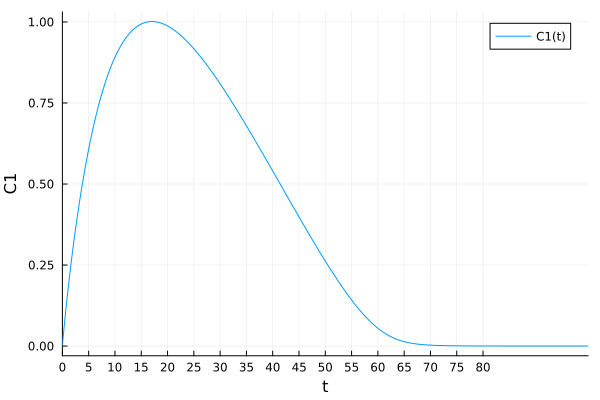

In [3]:
plot(C1_sol, xaxis=0.:5.:80., xlabel = "t", ylabel = "C1", label="C1(t)")

We use two *pseudo-experimental* datasets for `C1(t)` to fit the parameters of the model. The datasets are generated according to 

$$ C1\_data = C1\_sol*(1+ \epsilon) $$

where $$ \epsilon \sim Normal(0,\sigma)\\ \sigma =0.15 $$

First dataset ("up") includes `C1(t)` pseudo-experimental values for $t \in (0, 8)$ time interval and second ("down") dataset includes `C1(t)` values corresponding to $t \in (20, 100)$.

In [4]:
# upload the datasets
C1_data_up = CSV.read("data_pk_saturation_C1_up.csv",types=Dict("t"=>Float64), DataFrame)
C1_data_down = CSV.read("data_pk_saturation_C1_down.csv",types=Dict("t"=>Float64), DataFrame);

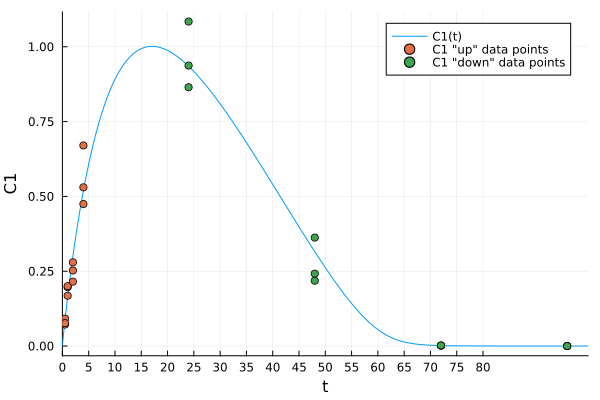

In [5]:
plot(C1_sol, xaxis=0.:5.:80.,xlabel = "t", ylabel = "C1", label="C1(t)");
scatter!(C1_data_up[!,:t],C1_data_up[!,:C1], label = "C1 \"up\" data points");
scatter!(C1_data_down[!,:t],C1_data_down[!,:C1], label = "C1 \"down\" data points")

To fit parameters `Vd, kabs, Vmax, Km` to sudo-experimental data we use the following loss function

$$ \Lambda = n*ln(2\pi\sigma^2) + \frac{1}{\sigma^2}\sum_{i=0}^n \left(\frac{y(t_i) - \tilde y_i}{y(t_i)}\right)^2 $$

Here 
$n$ - number of observations (experimental data time points),
$\tilde y_i$ - experimental data,
$y(t_i)$ - numerical solution
$\sigma$ - unknown distribution parameter fitted together with other parameters

In [6]:
# loss function 
function loss_func(sol, data)
    loss = 0.0
    σ = sol.prob.p[5]
    for (i,t) in enumerate(data[!,:t])
        y_sol = sol(t)[1]
        y_data = data[!,:C1][i]
        loss += ((y_sol - y_data)/y_sol)^2
    end
    loss = length(data[!,:t])*log(2*π*σ^2) + 1/σ^2 * loss
end;

Objective function is a wrapper for parameters updates during fitting `obj_func = (params,data)->loss`

In [7]:
# obj function (params,prob)->loss
function obj_func(params, 
                  data;
                  prob=prob, 
                  solver_opts=solver_opts, 
)
    prob_p = remake(prob,p=params)
    sol_p = solve(prob_p, 
                  solver_opts[:alg], 
                  reltol=solver_opts[:reltol], 
                  abstol=solver_opts[:abstol], 
                  dtmax=solver_opts[:dtmax], 
                  save_idxs = [2])
    loss_func(sol_p, data)
end;

Now we fit parameters `Vd, kabs, Vmax, Km and σ` to both ("up" and "down") datasets with *NLopt* package. See [NLopt documentation](https://nlopt.readthedocs.io/en/latest) for details

In [8]:
# fitting algorithm and search bounds
fitter_opts = Dict(
    :alg => :LN_NELDERMEAD,
    :bounds => (1e-9, 1e4)
)

opt_up = Opt(fitter_opts[:alg], length(p0))
opt_up.min_objective = (p,grad) -> obj_func(p, C1_data_up)
lower_bounds!(opt_up, fitter_opts[:bounds][1])
upper_bounds!(opt_up, fitter_opts[:bounds][2])

opt_down = Opt(fitter_opts[:alg], length(p0))
opt_down.min_objective = (p,grad) -> obj_func(p, C1_data_down)
lower_bounds!(opt_down, fitter_opts[:bounds][1])
upper_bounds!(opt_down, fitter_opts[:bounds][2]);

In [9]:
(loss_up,p_up,ret_up) = NLopt.optimize(opt_up, p0)

(-9.39881302932036, [0.00022785577797462537, 4.365081869530027e-6, 2.457224398059991e-5, 0.2402544962023706, 0.16226160739571255], :XTOL_REACHED)

In [10]:
(loss_down,p_down,ret_down) = NLopt.optimize(opt_down, p0)

(-13.369250011359478, [4.991033022492553, 0.10221735341475104, 0.21276486877541254, 0.12823028389349878, 0.13862392104412236], :XTOL_REACHED)

Now we can plot fitted `C1(t)` vs. default numerical solution

In [11]:
C1_sol_up = solve(remake(prob,p=p_up), 
                  solver_opts[:alg], 
                  reltol=solver_opts[:reltol], 
                  abstol=solver_opts[:abstol], 
                  dtmax=solver_opts[:dtmax], 
                  save_idxs = [2])

C1_sol_down = solve(remake(prob,p=p_down),
                    solver_opts[:alg], 
                    reltol=solver_opts[:reltol], 
                    abstol=solver_opts[:abstol], 
                    dtmax=solver_opts[:dtmax], 
                    save_idxs = [2]);

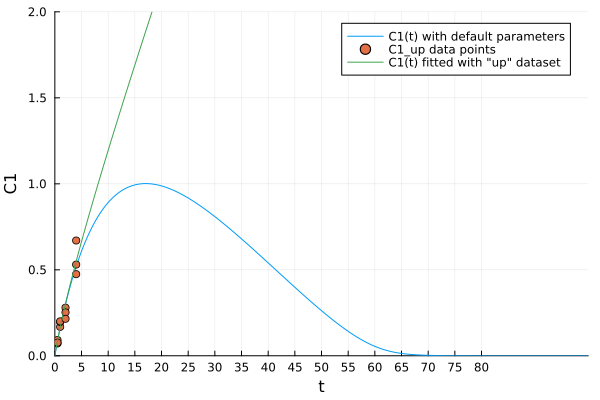

In [12]:
plot(C1_sol, xaxis=0.:5.:80.,xlabel = "t", ylabel = "C1", label="C1(t) with default parameters");
scatter!(C1_data_up[!,:t],C1_data_up[!,:C1], label = "C1_up data points");
plot!(C1_sol_up,ylims=(0,2),label="C1(t) fitted with \"up\" dataset")

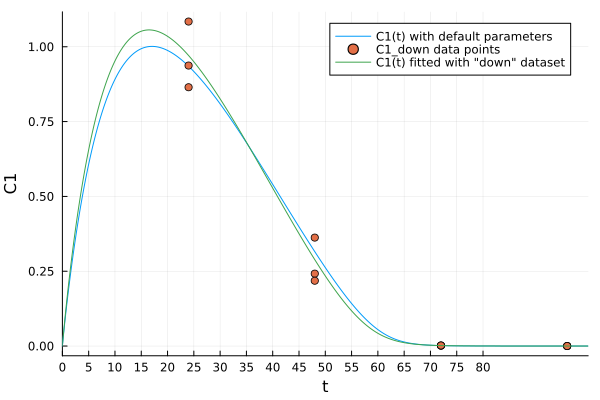

In [13]:
plot(C1_sol, xaxis=0.:5.:80.,xlabel = "t", ylabel = "C1", label="C1(t) with default parameters");
scatter!(C1_data_down[!,:t],C1_data_down[!,:C1], label = "C1_down data points");
plot!(C1_sol_down,label="C1(t) fitted with \"down\" dataset")

Let's use *LikelihoodProfiler* package to determine identifiable parameters and compute confidence intrvals.
We choose identification confidence level $ \alpha = loss + 3.84$, where $loss $ is the minimum loss function value obtained during fitting and 3.84 is *Chi-square statistics* with 1 degree of freedom and P-value=0.05.
Please, look up [LikelihoodProfiler documentation](https://insysbio.github.io/LikelihoodProfiler.jl/latest/) for details

In [14]:
α_up = loss_up + 3.84
α_down = loss_down + 3.84

C1_up_interval = [get_interval(
    p_up,
    i,
    (p)->obj_func(p,C1_data_up),
    :CICO_ONE_PASS,
    loss_crit = α_up,
    theta_bounds = [(1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12)],
    scan_bounds = (1e-6, 1e6),
    scan_tol = 1e-4
        ,
    scale = [:log, :log, :log, :log, :log]
) for i in 1:5]

C1_down_interval = [get_interval(
    p_down,
    i,
    (p)->obj_func(p,C1_data_down),
    :CICO_ONE_PASS,
    loss_crit = α_down,
    theta_bounds = [(1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12), (1e-12, 1e12)],
    scan_bounds = (1e-6, 1e6),
    scan_tol = 1e-4,
    scale = [:log, :log, :log, :log, :log]
) for i in 1:5];

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\evgen\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
right CP counter: 1166    Time: 0:00:01 ( 1.00 ms/it)


Parameters confidence intervals computed for "up" dataset (missing values mark non-identifiable bounds)

In [15]:
ENV["COLUMNS"]=120
df_up = DataFrame(
    Parameters = [:Vd, :kabs, :Vmax, :Km, :σ], 
    StatusLower = [p.result[1].status for p in C1_up_interval],
    Status_upper = [p.result[2].status for p in C1_up_interval],
    CILower = [p.result[1].value for p in C1_up_interval],
    CIUpper = [p.result[2].value for p in C1_up_interval],
    FittedValues = p_up,
    NominalValues = p0
)
df_up

Row,Parameters,StatusLower,Status_upper,CILower,CIUpper,FittedValues,NominalValues
,Symbol,Symbol,Symbol,Union…,Union…,Float64,Float64
1,Vd,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,13.9319,0.000227856,5.3
2,kabs,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,3.52942e-5,4.36508e-6,0.1
3,Vmax,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,0.000510333,2.45722e-5,0.2
4,Km,SCAN_BOUND_REACHED,SCAN_BOUND_REACHED,,,0.240254,0.1
5,σ,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.115229,0.255139,0.162262,0.05


Parameters confidence intervals computed for "down" dataset (missing values mark non-identifiable bounds)

In [16]:
df_down = DataFrame(
    Parameters = [:Vd, :kabs, :Vmax, :Km, :σ], 
    StatusLower = [p.result[1].status for p in C1_down_interval],
    StatusUpper = [p.result[2].status for p in C1_down_interval],
    CILower = [p.result[1].value for p in C1_down_interval],
    CIUpper = [p.result[2].value for p in C1_down_interval],
    FittedValues = p_down,
    TrueValues = p0
)
df_down

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,FittedValues,TrueValues
,Symbol,Symbol,Symbol,Float64,Float64,Float64,Float64
1,Vd,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,4.39346,5.89686,4.99103,5.3
2,kabs,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0998991,0.10462,0.102217,0.1
3,Vmax,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.207645,0.225751,0.212765,0.2
4,Km,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.114286,0.164454,0.12823,0.1
5,σ,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.106841,0.202707,0.138624,0.05
